In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [7]:
from utils import plot_spikes_in_time
from scnn import SNN
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
time_expector = TimeExpector()

In [8]:
batch_size = 4
nb_epochs = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

test_run = True
if test_run:
    print('[WARNING] : This is test run.')

[WARNING] : This is test run.


In [9]:
def plot_one_batch(network):
    for X_batch, _ in load_data('train'):
        break

    network.predict(X_batch)

    for i,l in enumerate(network.layers):
        if 'spk_rec_hist' in l.__dict__:
            print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
            if l.HAS_PARAM:
                plot_spikes_in_time(l)

In [10]:
# FIXME
my_laptop = False
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    if test_run:
        trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=60
    )

# calculate train dataset size
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])
for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

pre-processing dataset: 175
pre-processing dataset: 175


In [20]:
network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector


tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)

# network.add_dense( #layer(LegacyDense,
#     input_shape=4096,
#     output_shape=128,              
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

# network.add_layer(NewSpiker,
#     input_shape=4096,
#     output_shape=128,
                  
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_conv3d(
    input_shape=(64,64),
    output_shape=(64,64),
    input_channels=1,
    output_channels=1,
    kernel_size=(1,1,1),
    dilation=(1,1,1),
    lateral_connections=False,
    
    w_init_mean=1.0,
    w_init_std=0.01
)

network.add_pool2d(kernel_size=(4,4), output_channels=1)


network.add_dense(
    input_shape=256,
    output_shape=128,
    w_init_mean=0.0,
    w_init_std=weight_scale
#     lateral_connections=True
)

# network.add_layer(SpikingDenseLayer,
#     output_shape=256
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=128,
#     w_init_mean=.19
# )

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!

Layer 0: average number of spikes=0.0994


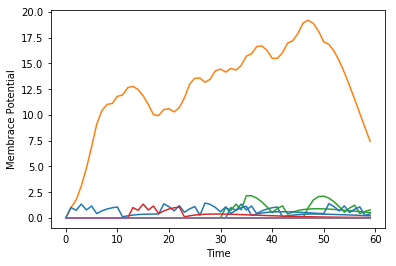

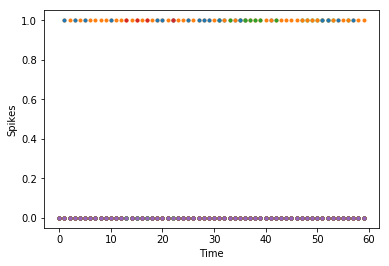

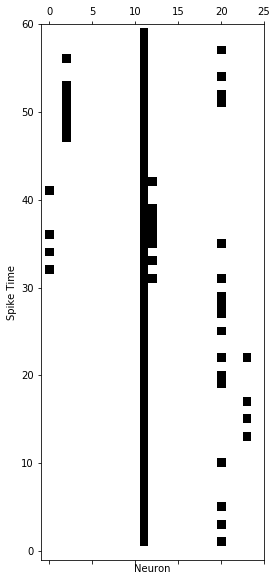

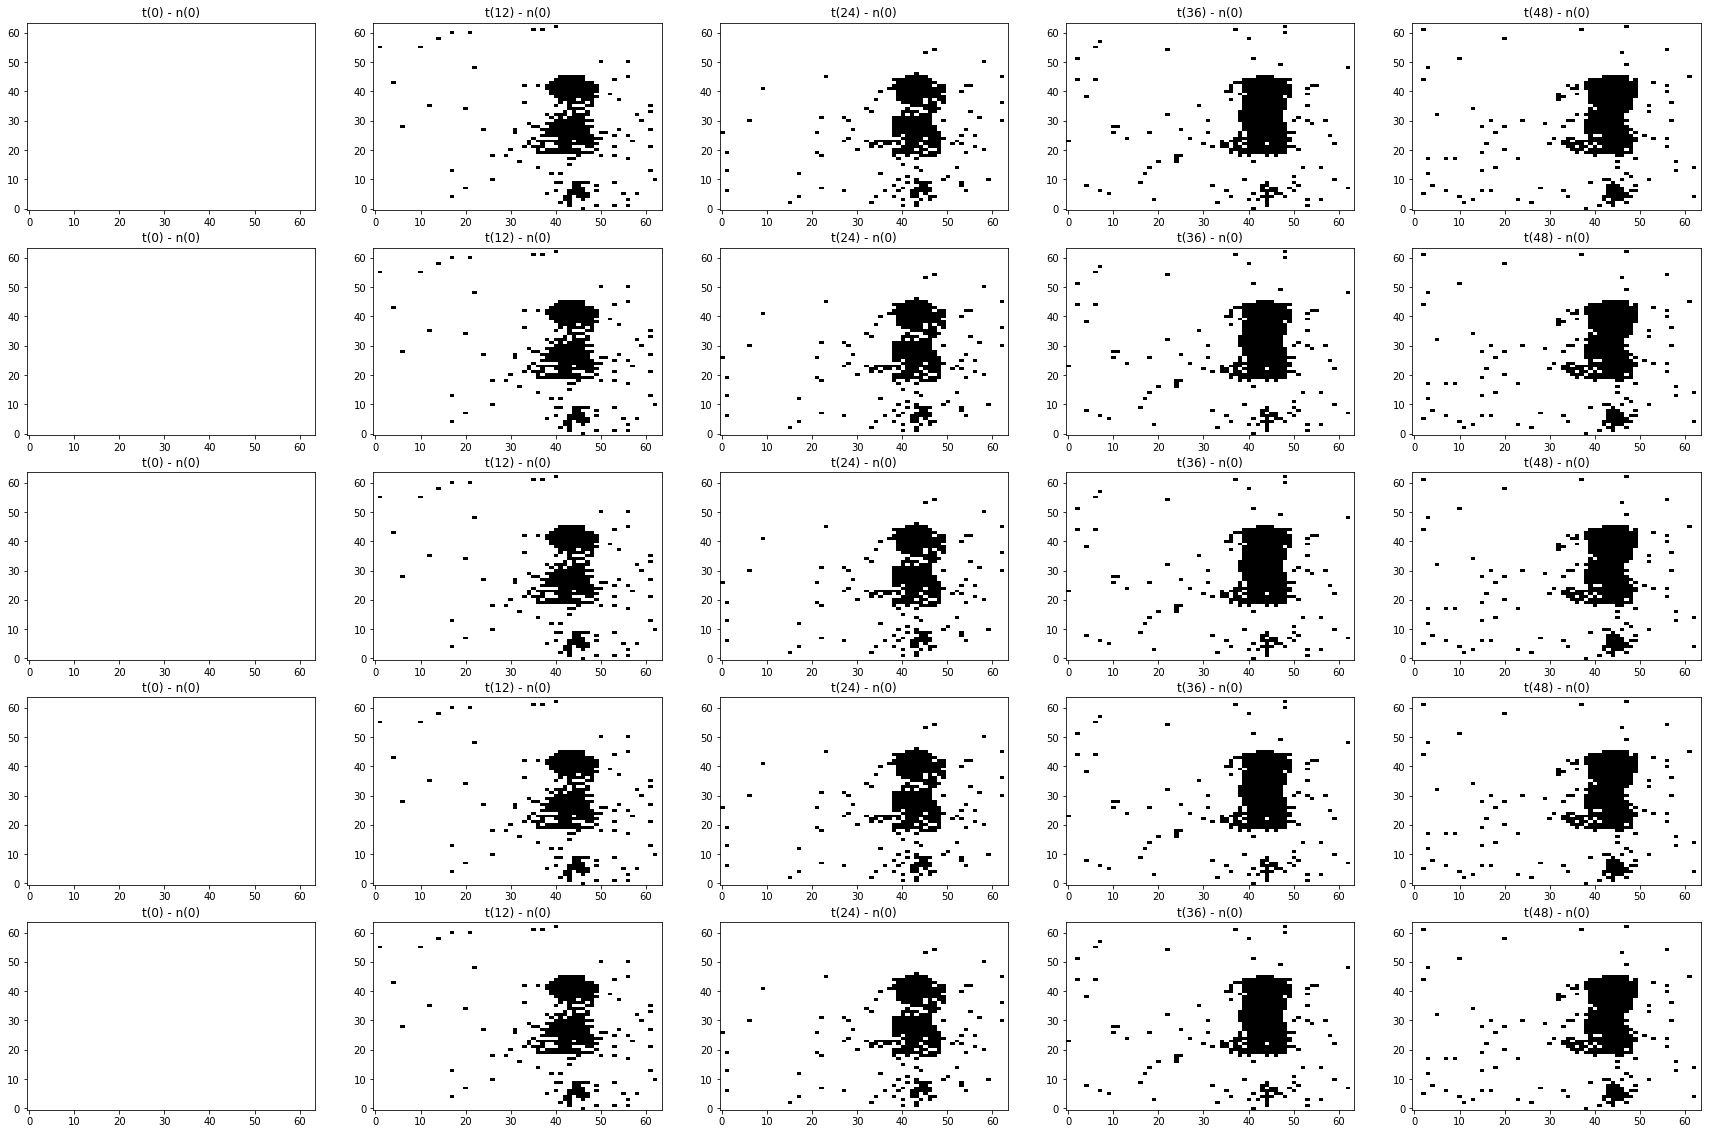

Layer 1: average number of spikes=0.3967
Layer 2: average number of spikes=0.3650


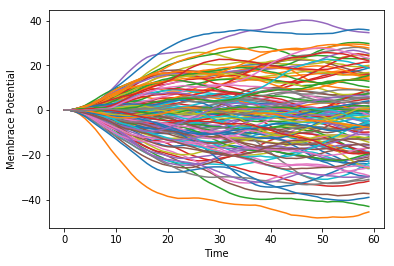

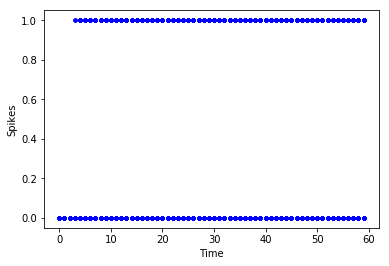

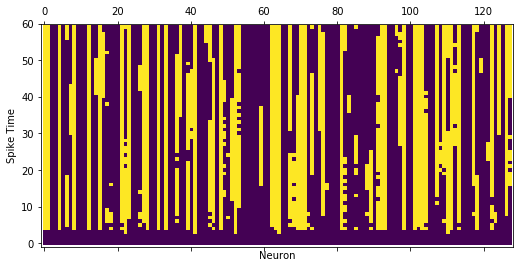

In [ ]:
plot_one_batch(network)

In [ ]:
with open('results.log', 'w') as f:
    # opt = RAdam(network.get_trainable_parameters())
    opt = torch.optim.SGD(network.get_trainable_parameters(), lr=1e-3, momentum=0.9)
    network.fit(load_data, epochs=nb_epochs, optimizer=opt, dataset_size=dataset_size, result_file=f)

network.save('save_network.net')
# network.load('save_network.net')
    
print('\n----------------------------------------')
train_accuracy = network.compute_classification_accuracy(load_data('acc_train'))
print("Final Train Accuracy=%.2f%%"%(train_accuracy * 100.))
test_accuracy = network.compute_classification_accuracy(load_data('acc_test'))
print("Final Test Accuracy=%.2f%%"%(test_accuracy * 100.))

[WARNING] calling "tick" without a "tock"...
[expecting to finish at 2020-04-22 12:53:58]
Epoch: 0 [===========================================================>] 100%      | loss=2.389 val_loss=2.355
train_accuracy=19.57%  |  valid_accuracy=19.57%
[operation finished at 2020-04-22 11:12:50  -  took 1 minutes]
[expecting to finish at 2020-04-22 12:30:54]
Epoch: 1 [------------------------------------------>.................] 70%    

In [ ]:
plot_one_batch(network)

In [ ]:
# network.predict(X_batch)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM or 'spk_rec_hist' not in l.__dict__:
#         continue
        
#     if isinstance(l, SpikingDenseLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, 0)